# Titanic

In [1]:
import pandas as pd
import seaborn as sns

## Tratamento

### Escolhendo as colunas

In [2]:
train = pd.read_csv('Titanic Data/train.csv')
test = pd.read_csv('Titanic Data/test.csv')

In [3]:
# Vamos ver as variáveis disponíveis
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Quantos valores nulos temos por atributo
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
# Vamos remover Cabin, por ter muitos valores nulos, e outras não relevantes
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

### Tratando valores nulos

In [7]:
# Vamos analisar a váriavel Age, para estudar a melhor forma de preencher valores nulos
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

<AxesSubplot:xlabel='Age', ylabel='Count'>

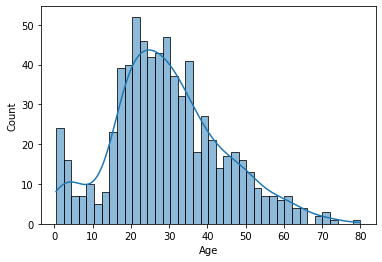

In [8]:
# Sua distribuição também
sns.histplot(train['Age'], bins=40, kde=True)

In [9]:
# Vamos preencher com a média
train['Age'].fillna(train['Age'].mean(), inplace=True)
test['Age'].fillna(test['Age'].mean(), inplace=True)

In [10]:
# Sobraram poucos valores nulos, então vamos remover essas entradas
train.dropna(inplace=True)
test.dropna(inplace=True)

### Tratamento de tipo

In [11]:
# Verificando o tipo de cada variável
train.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [12]:
train['Sex'].unique()

array(['male', 'female'], dtype=object)

In [13]:
replace_gender = lambda s: 0 if s == 'male' else 1

train['Sex'] = train['Sex'].apply(replace_gender)
test['Sex'] = test['Sex'].apply(replace_gender)

In [14]:
test['Embarked'].unique()

array(['Q', 'S', 'C'], dtype=object)

In [15]:
replace_embarked = lambda e: 0 if e == 'Q' else 1 if e == 'S' else 2

train['Embarked'] = train['Embarked'].apply(replace_embarked)
test['Embarked'] = test['Embarked'].apply(replace_embarked)

### Análise de correlação

<AxesSubplot:>

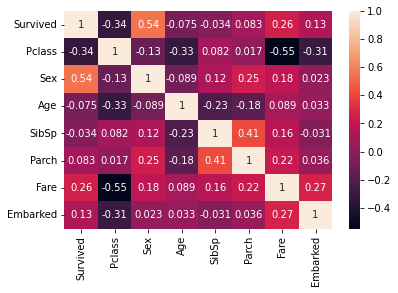

In [18]:
# matriz de correlação
sns.heatmap(train.corr(), annot=True)

### Normalização

In [16]:
train.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,0.350956,29.653446,0.524184,0.382452,32.096681,1.102362
std,0.486260,0.834700,0.477538,12.968366,1.103705,0.806761,49.697504,0.515181
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.895800,1.000000
50%,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000
